<a href="https://colab.research.google.com/github/Duplexus/Basketball/blob/main/Object_detection_anpassen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/experiencor/raccoon_dataset.git

Cloning into 'raccoon_dataset'...
remote: Enumerating objects: 646, done.
remote: Total 646 (delta 0), reused 0 (delta 0), pack-reused 646
Receiving objects: 100% (646/646), 48.00 MiB | 21.27 MiB/s, done.
Resolving deltas: 100% (412/412), done.


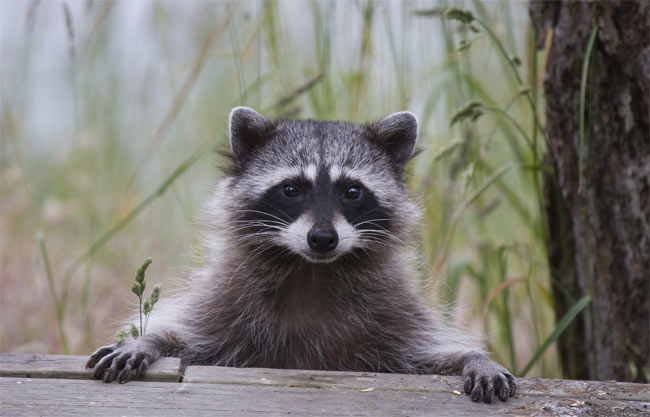

In [2]:
from PIL import Image
image = Image.open("/content/raccoon_dataset/images/raccoon-1.jpg")
image

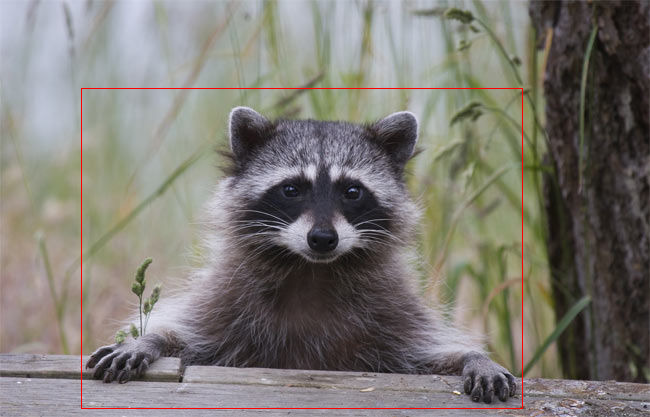

In [3]:
from PIL import ImageDraw
xmin = 81
ymin = 88
xmax = 522
ymax = 408
draw = ImageDraw.Draw(image)
draw.rectangle([(xmin, ymin), (xmax, ymax)], outline ="red")
image

In [4]:
import pandas as pd
labels = pd.read_csv("/content/raccoon_dataset/data/raccoon_labels.csv")
labels.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-1.jpg,650,417,raccoon,81,88,522,408
1,raccoon-10.jpg,450,495,raccoon,130,2,446,488
2,raccoon-100.jpg,960,576,raccoon,548,10,954,520
3,raccoon-101.jpg,640,426,raccoon,86,53,400,356
4,raccoon-102.jpg,259,194,raccoon,1,1,118,152


In [5]:
import pycocotools

In [6]:
! mkdir pytorch_object_detection

In [7]:
import os
os.chdir("/content/pytorch_object_detection")
os.getcwd()

'/content/pytorch_object_detection'

In [8]:
!git clone https://github.com/pytorch/vision.git

Cloning into 'vision'...
remote: Enumerating objects: 110049, done.
remote: Counting objects: 100% (2734/2734), done.
remote: Compressing objects: 100% (664/664), done.
remote: Total 110049 (delta 2475), reused 2208 (delta 2056), pack-reused 107315
Receiving objects: 100% (110049/110049), 213.06 MiB | 6.35 MiB/s, done.
Resolving deltas: 100% (95146/95146), done.


In [9]:
!cd vision && git checkout v0.3.0

Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084d version check against PyTorch's CUDA version


In [11]:
!cd vision && cp references/detection/utils.py ../
!cd vision && cp references/detection/transforms.py ../
!cd vision && cp references/detection/coco_eval.py ../
!cd vision && cp references/detection/engine.py ../
!cd vision && cp references/detection/coco_utils.py ../

In [12]:
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import pandas as pd

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [13]:
def parse_one_annot(path_to_data_file, filename):
   data = pd.read_csv(path_to_data_file)
   boxes_array = data[data["filename"] == filename][["xmin", "ymin",        
   "xmax", "ymax"]].values
   
   return boxes_array

In [14]:
class RaccoonDataset(torch.utils.data.Dataset):
    def __init__(self, root, data_file, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, "images")))
        self.path_to_data_file = data_file

    def __getitem__(self, idx):
        # load images and bounding boxes
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        box_list = parse_one_annot(self.path_to_data_file,self.imgs[idx])
        boxes = torch.as_tensor(box_list, dtype=torch.float32)
        num_objs = len(box_list)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
           img, target = self.transforms(img, target)
        return img, target 

    def __len__(self):
        return len(self.imgs)

In [15]:
dataset = RaccoonDataset(root= "/content/raccoon_dataset",data_file= "/content/raccoon_dataset/data/raccoon_labels.csv")
dataset.__getitem__(0)


(<PIL.Image.Image image mode=RGB size=650x417 at 0x7FA16E91EBD0>,
 {'area': tensor([141120.]),
  'boxes': tensor([[ 81.,  88., 522., 408.]]),
  'image_id': tensor([0]),
  'iscrowd': tensor([0]),
  'labels': tensor([1])})

In [16]:
def get_model(num_classes):
   # load an object detection model pre-trained on COCO
   model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
   # get the number of input features for the classifier
   in_features = model.roi_heads.box_predictor.cls_score.in_features
   # replace the pre-trained head with a new on
   model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)
   
   return model

In [17]:
def get_transform(train):
   transforms = []
   # converts the image, a PIL image, into a PyTorch Tensor
   transforms.append(T.ToTensor())
   if train:
      # during training, randomly flip the training images
      # and ground-truth for data augmentation
      transforms.append(T.RandomHorizontalFlip(0.5))
   return T.Compose(transforms)

In [40]:
dataset = RaccoonDataset(root= "/content/raccoon_dataset",data_file= "/content/raccoon_dataset/data/raccoon_labels.csv",
          transforms = get_transform(train=True))
dataset_test = RaccoonDataset(root= "/content/raccoon_dataset", data_file= "/content/raccoon_dataset/data/raccoon_labels.csv",
               transforms = get_transform(train=False))

# split the dataset in train and test settorch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-180])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-180:])
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
              dataset, batch_size=2, shuffle=True, num_workers=4,
              collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(
         dataset_test, batch_size=1, shuffle=False, num_workers=4,
         collate_fn=utils.collate_fn)
print("We have: {} examples, {} are training and {} testing".format(len(indices), len(dataset), len(dataset_test)))

We have: 200 examples, 20 are training and 180 testing


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [41]:
torch.cuda.is_available()
import torchvision

In [42]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# our dataset has two classes only - raccoon and not racoon
num_classes = 2
# get the model using our helper function
model = get_model(num_classes)
# move model to the right device
model.to(device)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler which decreases the learning rate by # 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
# let's train it for 10 epochs
num_epochs = 10
for epoch in range(num_epochs):
   # train for one epoch, printing every 10 iterations
   train_one_epoch(model, optimizer, data_loader, device, epoch,
                   print_freq=10)# update the learning rate
   lr_scheduler.step()
   # evaluate on the test dataset
   evaluate(model, data_loader_test, device=device)

In [ ]:
#os.mkdir("/content/pytorch_object_detection/raccoon/")
torch.save(model.state_dict(), "/content/pytorch_object_detection/raccoon/model")

In [ ]:
loaded_model = get_model(num_classes = 2)
loaded_model.load_state_dict(torch.load("/content/pytorch_object_detection/raccoon/model"))

<All keys matched successfully>

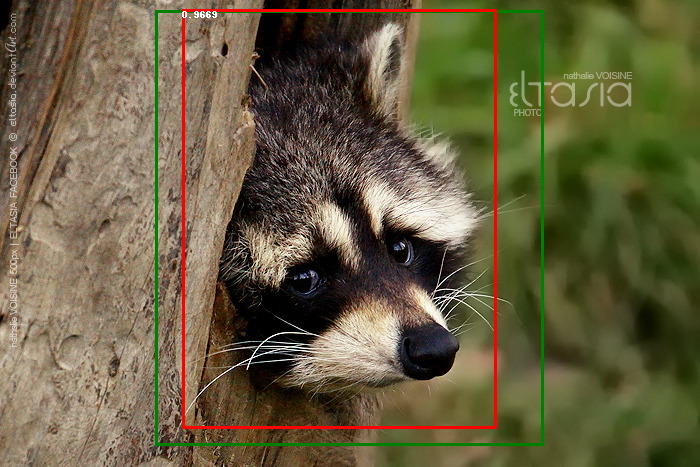

In [ ]:
idx = 23
img, _ = dataset_test[idx]
label_boxes = np.array(dataset_test[idx][1]["boxes"])

#put the model in evaluation mode
loaded_model.eval()

with torch.no_grad():
   prediction = loaded_model([img])

image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
draw = ImageDraw.Draw(image)

# draw groundtruth
for elem in range(len(label_boxes)):
   draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
   (label_boxes[elem][2], label_boxes[elem][3])], 
   outline ="green", width =3)

for element in range(len(prediction[0]["boxes"])):
   boxes = prediction[0]["boxes"][element].cpu().numpy()
   score = np.round(prediction[0]["scores"][element].cpu().numpy(),
                    decimals= 4)
   if score > 0.8:
      draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
      outline ="red", width =3)
      draw.text((boxes[0], boxes[1]), text = str(score))
image

In [22]:
import time
import fastprogress


In [52]:
def train(dataloader, optimizer, model, device, master_bar, scaler):
    model.train()
    epoch_loss = []
    for images, targets in fastprogress.progress_bar(dataloader, parent=master_bar):
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
      with torch.cuda.amp.autocast(enabled= scaler is not None):
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
      # reduce losses over all GPUs for logging purposes
      loss_dict_reduced = utils.reduce_dict(loss_dict)
      losses_reduced = sum(loss for loss in loss_dict_reduced.values())
      loss_value = losses_reduced.item()

      # zero gradient
      optimizer.zero_grad()

      # Forward pass
      #is already done with the step model(images, targets)

      # loss calculation
      loss = loss_value

      # Backward pass
      if scaler is not None:
	      scaler.scale(losses).backward()
	      scaler.step(optimizer)
	      scaler.update()
      else:
        loss.backward()
        optimizer.step()
      # For plotting the train loss, save it for each sample
      epoch_loss.append(torch.tensor(loss).item())
    return np.mean(epoch_loss)

def validate(dataloader, model, device, master_bar, scaler):
    model.eval()
    epoch_loss = []

    with torch.no_grad():
      for images, targets in fastprogress.progress_bar(dataloader, parent=master_bar):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.cuda.amp.autocast(enabled=scaler is not None):
          loss_dict = model(images, targets)
        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        print(loss_dict)
        print(type(loss_dict))
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        loss_value = losses_reduced.item()

        # zero gradient
        optimizer.zero_grad()

        # loss calculation
        loss = loss_value

        # For plotting the train loss, save it for each sample
        epoch_loss.append(torch.tensor(loss).item())
    return np.mean(epoch_loss)


def run_training(model, optimizer,device, num_epochs,
                 train_dataloader, val_dataloader, verbose=True, scaler=True):
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses  = [], []

    if scaler:
        scaler = torch.cuda.amp.GradScaler()

    for epoch in master_bar:
        # Train the model
        epoch_train_loss  = train(train_dataloader, optimizer, model, device, master_bar, scaler)
        # Validate the model
        epoch_val_loss = validate(val_dataloader, model,
                                                 device, master_bar, scaler)
        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)

        if verbose:
            master_bar.write(
                f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}')

    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses

In [53]:
run_training(model, optimizer, device, 2,data_loader, data_loader_test)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'boxes': tensor([[ 33.8148,  26.8892, 313.4553, 327.4333],
        [ 64.0366,  75.8174, 210.0300, 280.0670],
        [111.9192,  85.7688, 294.9402, 285.9574]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9731, 0.7555, 0.2885], device='cuda:0')}]
<class 'list'>


AttributeError: ignored

In [51]:
%debugqui

> <ipython-input-49-ac55a2911821>(58)validate()
     56 
     57         # For plotting the train loss, save it for each sample
---> 58         epoch_loss.append(torch.tensor(loss).item())
     59     return np.mean(epoch_loss)
     60 

--KeyboardInterrupt--
ipdb> quit
ipdb> quit
